Variable names used :
- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer mentioned in **LLM_Scratch_Token_Embedding.ipynb**
- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings mentioned in **LLM_Scratch_Token_Embedding.ipynb**
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism implemented in mentioned in **LLM_Scratch_Attention.ipynb**
- `"n_layers"` is the number of transformer blocks within the model, which is implemented here below
- `"drop_rate"` is the dropout mechanism's intensity; 0.1 means dropping 10% of hidden units during training to mitigate overfitting
- `"qkv_bias"` decides if the Linear layers in the multi-head attention mechanism (**LLM_Scratch_Attention.ipynb**) should include a bias vector when computing query (Q), key (K), and value (V) tensors; disabling this option here, which is standard practice in modern LLMs; however, it is reimplementated in **LLM_Scratch_Training_Pretraining.ipynb** when loading pretrained GPT-2 weights from OpenAI

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [3]:
import torch
import torch.nn as nn

## Placeholder GPT model architecture class

In [4]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Placeholder TransformerBlock class

In [5]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x

## Placeholder LayerNorm class

In [6]:
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [7]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [8]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)    # GPT_CONFIG_124M defined above

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## Layer Normalization - Normalizing activations

- Layer normalization, also known as LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450/)), centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1
- This stabilizes training and enables faster convergence to effective weights*
- Layer normalization is **applied both before and after the multi-head** attention module within the transformer block and also **applied before the final output layer**

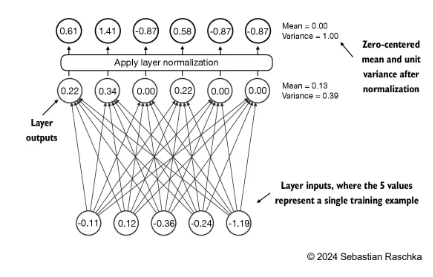

*Stable training explanation

- Training deep neural networks with many layers can sometimes prove challenging due to problems like vanishing or exploding gradients.
- These problems lead to unstable training dynamics and make it difficult for the network to effectively adjust its weights, which means the learning process struggles to find a set of parameters
(weights) for the neural network that minimizes the loss function.
- In other words, the network has difficulty learning the underlying patterns in the data to a degree that
would allow it to make accurate predictions or decisions

In [11]:
torch.randn(2, 5)

tensor([[-0.5995,  0.6999, -2.7565,  0.3921, -1.3160],
        [ 0.0785, -1.3012,  0.4333,  0.5574, -0.6766]])

In [9]:
nn.Linear(5, 6)

Linear(in_features=5, out_features=6, bias=True)

In [10]:
nn.Sequential(nn.Linear(5, 6), nn.ReLU())

Sequential(
  (0): Linear(in_features=5, out_features=6, bias=True)
  (1): ReLU()
)

An exmaple to see how layer normalization works by passing a small input sample through a simple neural network layer

In [12]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- The normalization is applied to each of the two inputs (rows) independently; using `dim=-1` applies the calculation across the last dimension (in this case, the feature dimension) instead of the row dimension

In [13]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


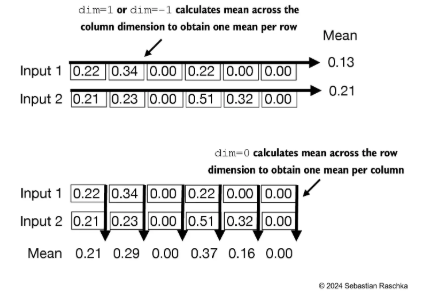

- Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension

In [14]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Each input is centered at 0 and has a unit variance of 1; to improve readability, we can disable PyTorch's scientific notation

In [15]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Layer Normalization Class

In [17]:
torch.ones(5), torch.zeros(5)

(tensor([1., 1., 1., 1., 1.]), tensor([0., 0., 0., 0., 0.]))

In [18]:
nn.Parameter(torch.ones(5)), nn.Parameter(torch.zeros(5))

(Parameter containing:
 tensor([1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.], requires_grad=True))

In [19]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**Scale and shift**

- Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, two trainable parameters, a `scale` and a `shift` parameter are also added
- The initial `scale` (multiplying by 1) and `shift` (adding 0) values don't have any effect; however, `scale` and `shift` are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task
- This allows the model to learn appropriate scaling and shifting that best suit the data it is processing
- A small value (`eps`) is also added before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0

**Biased variance**

- In the variance calculation above, setting `unbiased=False` means using the formula $ \frac{Σ_t(x_t-\bar{x})^2}{n} $ to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses n-1 in the denominator), thus providing a biased estimate of the variance
- For LLMs, where the embedding dimension `n` is very large, the difference between using `n` and `n-1` is negligible
- GPT-2 was trained with a biased variance in the normalization layers, using same setting for compatibility reasons with the pretrained weights that we will load in later chapters

In [20]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
print(out_ln)

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)


In [21]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## Feed Forward Network with GELU activations

- Small neural network submodule that is used as part of the transformer block in LLMs
- In deep learning, **ReLU (Rectified Linear Unit)** activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
- In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are **GELU (Gaussian Error Linear Unit)** and **SwiGLU (Swish-Gated Linear Unit)**
- GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU
- GELU can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution
- In practice, it's common to implement a computationally cheaper approximation: $ GELU(x) \approx 0.5  · x  · (1 + tanh [\sqrt{\frac{2}{π}}  · {(x + 0.044715  · x^3)])}   $ (the original GPT-2 model was also trained with this approximation)

In [22]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

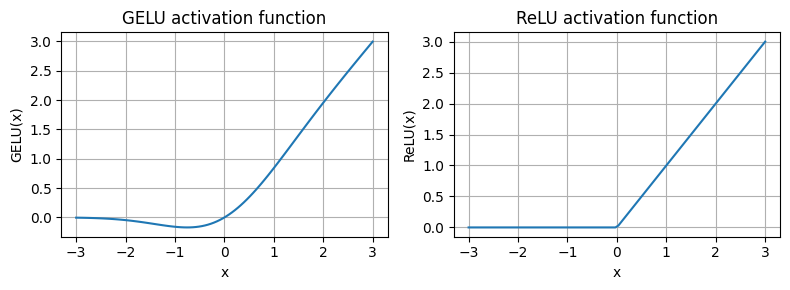

In [23]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero

- GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values (except at approximately -0.75)

In [24]:
torch.linspace(-3, 3, 100)

tensor([-3.0000, -2.9394, -2.8788, -2.8182, -2.7576, -2.6970, -2.6364, -2.5758,
        -2.5152, -2.4545, -2.3939, -2.3333, -2.2727, -2.2121, -2.1515, -2.0909,
        -2.0303, -1.9697, -1.9091, -1.8485, -1.7879, -1.7273, -1.6667, -1.6061,
        -1.5455, -1.4848, -1.4242, -1.3636, -1.3030, -1.2424, -1.1818, -1.1212,
        -1.0606, -1.0000, -0.9394, -0.8788, -0.8182, -0.7576, -0.6970, -0.6364,
        -0.5758, -0.5152, -0.4545, -0.3939, -0.3333, -0.2727, -0.2121, -0.1515,
        -0.0909, -0.0303,  0.0303,  0.0909,  0.1515,  0.2121,  0.2727,  0.3333,
         0.3939,  0.4545,  0.5152,  0.5758,  0.6364,  0.6970,  0.7576,  0.8182,
         0.8788,  0.9394,  1.0000,  1.0606,  1.1212,  1.1818,  1.2424,  1.3030,
         1.3636,  1.4242,  1.4848,  1.5455,  1.6061,  1.6667,  1.7273,  1.7879,
         1.8485,  1.9091,  1.9697,  2.0303,  2.0909,  2.1515,  2.2121,  2.2727,
         2.3333,  2.3939,  2.4545,  2.5152,  2.5758,  2.6364,  2.6970,  2.7576,
         2.8182,  2.8788,  2.9394,  3.00

In [25]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [26]:
print(GPT_CONFIG_124M["emb_dim"])

768


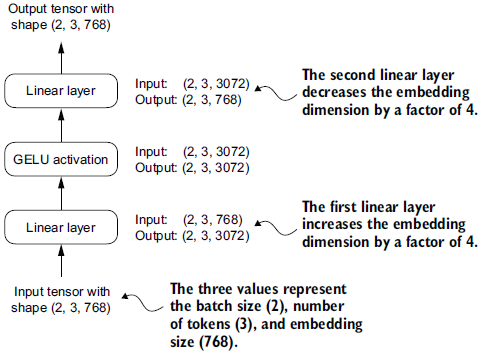

In [27]:
torch.rand(2, 3, 768)

tensor([[[0.1908, 0.9268, 0.5299,  ..., 0.2594, 0.1849, 0.2540],
         [0.4626, 0.4399, 0.1210,  ..., 0.6091, 0.6549, 0.5143],
         [0.4594, 0.7421, 0.8384,  ..., 0.2723, 0.0846, 0.5626]],

        [[0.5454, 0.2496, 0.1227,  ..., 0.5421, 0.8048, 0.2210],
         [0.9160, 0.7751, 0.1438,  ..., 0.2372, 0.6304, 0.7377],
         [0.1925, 0.7885, 0.9719,  ..., 0.2704, 0.9216, 0.5115]]])

In [28]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


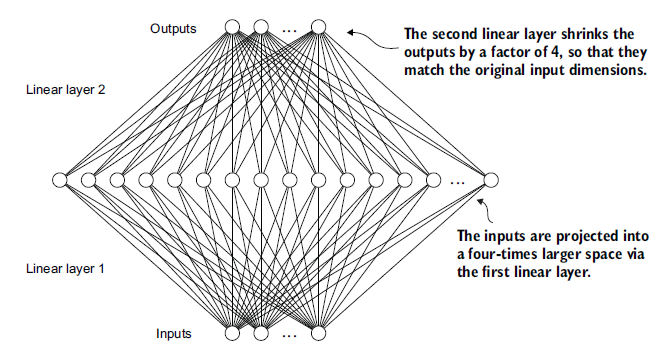

## Adding shortcut connections

- Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems
- A shortcut connection creates an alternative shorter path for the gradient to flow through the network
- This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between

In [29]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [30]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [31]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

# without shortcut
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [32]:
# with shortcut
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- It can be seen from the output above, shortcut connections prevent the gradients from vanishing in the early layers (towards layer.0)

# Transformer block - connecting attention and linear layers

- A transformer block combines the causal multi-head attention module with the linear layers, the feed forward neural network
- It also uses dropout and shortcut connections

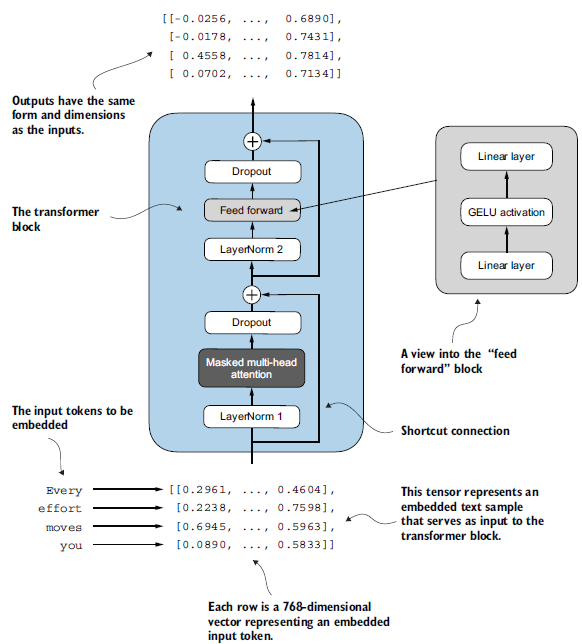

- For 2 input samples with 6 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size
- The output can be thought of as an augmented version of the context vectors

- MultiHeadAttention from LLM_Scratch_Attention.ipynb

In [33]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

In [34]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [35]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


- Layer normalization (LayerNorm) is applied before each of the two components, and dropout is applied after them to regularize the model and prevent overfitting. This is also known as **Pre-LayerNorm**.
- Older architectures, such as the original transformer model, applied layer normalization after the self-attention and feed forward networks
instead, known as **Post-LayerNorm**, which often leads to worse training dynamics.

# GPT Model

- The transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, it is repeated 12 times

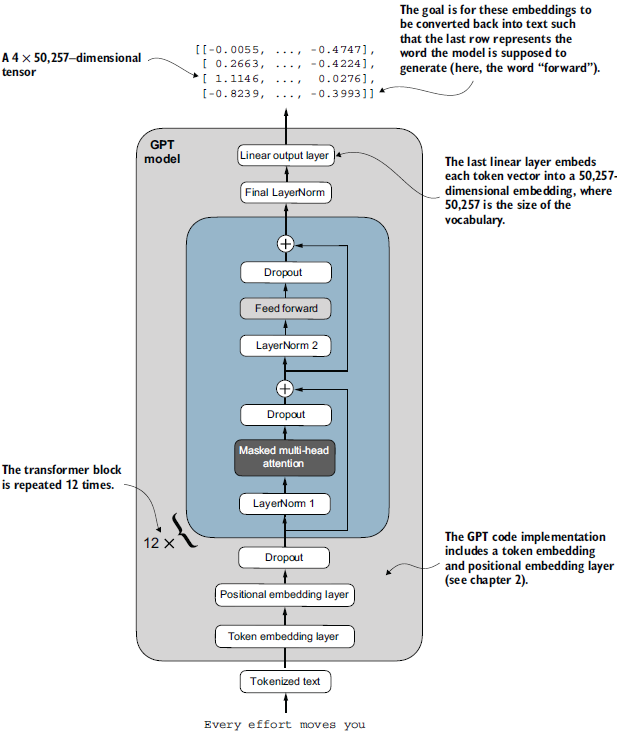

In [36]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- Using the configuration of the 124M parameter model, instantiating the above GPT model with random initial weights as follows

In [37]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [38]:
# Total Paramaeters

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- Here, the model has 163M, not 124M parameters
- In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
- The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words
- So, the embedding and output layer have the same number of weight parameters, as can be seen from the shape of their weight matrices


In [39]:
# To check for token embedding and output layer shape

print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [40]:
# subtracting output layer parameters from total parameters

total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


**Computing the memory requirements of the model**

In [41]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


### Generating Text

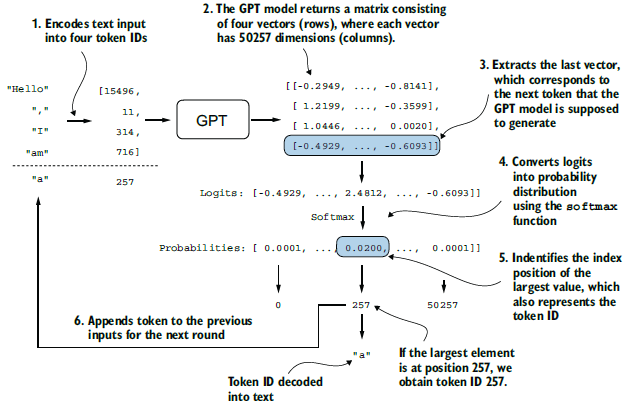

- The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
- In **greedy decoding**, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so no need to compute softmax function explicitly)

In [42]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

1. `idx_cond = idx[:, -context_size:]`

```
context_size = 5
tensor([[10, 20, 30, 40, 50, 60, 70],
        [15, 25, 35, 45, 55, 65, 75]])

```
Here, batch_size is 2 and sequence_length is 7.

Applying `idx_cond = idx[:, -context_size:]` (which is `idx[:, -5:])` will result in:
```
tensor([[30, 40, 50, 60, 70],
        [35, 45, 55, 65, 75]])

```
Here only the last 5 tokens from each original sequence are kept.

Because the model can only handle a fixed number of input tokens (context_size). By taking the last `context_size` tokens, it is ensured that the model is always processing a sequence of the correct length and focusing on the most recent context, which is usually the most relevant for predicting the next token.

2. `logits = logits[:, -1, :]`

- `logits`: This is the output of the model's forward pass. Its shape is `(batch_size, sequence_length, vocab_size)`.
  - `batch_size`: Same as before, the number of examples.
  - `sequence_length`: This is the number of tokens in the input sequence that was passed to the model (which is context_size or the original sequence length if it was shorter).
  - `vocab_size`: The total number of possible tokens in the model's vocabulary. The values in this dimension represent the raw, unnormalized scores for each possible next token.

- `-1`: Selects the last element along the second dimension (the sequence length dimension). In the context of language generation, the model predicts the probability distribution for the next token at each position in the input sequence. We are interested in the prediction for the token that comes after the last token of the input sequence.
:: This selects all elements along the last dimension (the vocabulary size dimension). We want the predictions for all possible tokens in the vocabulary.

Example:

Suppose logits tensor has a shape of (2, 5, 50257). So, there are 2 examples in the batch, the input sequence had 5 tokens, vocabulary size is 50257.

Applying `logits = logits[:, -1, :]` will result in a tensor with the shape `(2, 50257)`.

The resulting tensor logits now contains the predicted scores for each of the 50257 vocabulary tokens, for each of the 2 examples in the batch, specifically for the position after the last input token. These scores are then usually passed through a softmax function to get probabilities, and then the token with the highest probability is selected as the next token.

In [46]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)
print("encoded_tensor:", encoded_tensor)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
encoded_tensor: tensor([[15496,    11,   314,   716]])


In [47]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [48]:
# Remove batch dimension and convert back into text

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Note that the model is untrained; hence the random output texts above

### EXTRA

### 1. Parameters in the feed forward versus attention module

In [49]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

block = TransformerBlock(GPT_CONFIG_124M)
print(block)

TransformerBlock(
  (att): MultiHeadAttention(
    (W_query): Linear(in_features=768, out_features=768, bias=False)
    (W_key): Linear(in_features=768, out_features=768, bias=False)
    (W_value): Linear(in_features=768, out_features=768, bias=False)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ff): FeedForward(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU()
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm()
  (norm2): LayerNorm()
  (drop_shortcut): Dropout(p=0.1, inplace=False)
)


In [55]:
block_ff_params = sum(p.numel() for p in block.ff.parameters())
print(f"Total number of parameters in feed forward module: {block_ff_params:,}")

Total number of parameters in feed forward module: 4,722,432


In [56]:
block_att_params = sum(p.numel() for p in block.att.parameters())
print(f"Total number of parameters in attention module: {block_att_params:,}")

Total number of parameters in attention module: 2,360,064


- The results above are for a single transformer block
- Multiply by 12 to capture all transformer blocks in the 124M GPT model

In [57]:
total_ff_params = 12 * block_ff_params
print(f"Total number of parameters in feed forward module for all 12 blocks : {total_ff_params:,}")

Total number of parameters in feed forward module for all 12 blocks : 56,669,184


In [58]:
total_att_params = 12 * block_att_params
print(f"Total number of parameters in attention module for all 12 blocks : {total_att_params:,}")

Total number of parameters in attention module for all 12 blocks : 28,320,768


In [59]:
total_params = total_ff_params + total_att_params
print(f"Total number of parameters in all of 12 blocks : {total_params:,}")

Total number of parameters in all of 12 blocks : 84,989,952


 Mathematical breakdown

Assuming emb_dim=768

Feed forward module:

- 1st `Linear` layer: 768 inputs × 4×768 outputs + 4×768 bias units = 2,362,368
- 2nd `Linear` layer: 4×768 inputs × 768 outputs + 768 bias units = 2,360,064
- Total: 1st `Linear` layer + 2nd `Linear` layer = 2,362,368 + 2,360,064 = 4,722,432

Attention module:

- `W_query`: 768 inputs × 768 outputs = 589,824
- `W_key`: 768 inputs × 768 outputs = 589,824
-` W_value`: 768 inputs × 768 outputs = 589,824
- `out_proj`: 768 inputs × 768 outputs + 768 bias units = 590,592
- Total: `W_query` + `W_key` + `W_value` + `out_proj` = 3×589,824 + 590,592 = 2,360,064

### 2. Initializing larger GPT models


In [63]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [64]:
def get_config(base_config, model_name="gpt2-small"):
    GPT_CONFIG = base_config.copy()

    if model_name == "gpt2-small":
        GPT_CONFIG["emb_dim"] = 768
        GPT_CONFIG["n_layers"] = 12
        GPT_CONFIG["n_heads"] = 12

    elif model_name == "gpt2-medium":
        GPT_CONFIG["emb_dim"] = 1024
        GPT_CONFIG["n_layers"] = 24
        GPT_CONFIG["n_heads"] = 16

    elif model_name == "gpt2-large":
        GPT_CONFIG["emb_dim"] = 1280
        GPT_CONFIG["n_layers"] = 36
        GPT_CONFIG["n_heads"] = 20

    elif model_name == "gpt2-xl":
        GPT_CONFIG["emb_dim"] = 1600
        GPT_CONFIG["n_layers"] = 48
        GPT_CONFIG["n_heads"] = 25

    else:
        raise ValueError(f"Incorrect model name {model_name}")

    return GPT_CONFIG

In [65]:
def calculate_size(model): # based on chapter code

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,}")

    total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
    print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

    # Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
    total_size_bytes = total_params * 4

    # Convert to megabytes
    total_size_mb = total_size_bytes / (1024 * 1024)

    print(f"Total size of the model: {total_size_mb:.2f} MB")

In [66]:
for model_abbrev in ("small", "medium", "large", "xl"):
    model_name = f"gpt2-{model_abbrev}"
    CONFIG = get_config(GPT_CONFIG_124M, model_name=model_name)
    model = GPTModel(CONFIG)
    print(f"\n\n{model_name}:")
    calculate_size(model)



gpt2-small:
Total number of parameters: 163,009,536
Number of trainable parameters considering weight tying: 124,412,160
Total size of the model: 621.83 MB


gpt2-medium:
Total number of parameters: 406,212,608
Number of trainable parameters considering weight tying: 354,749,440
Total size of the model: 1549.58 MB


gpt2-large:
Total number of parameters: 838,220,800
Number of trainable parameters considering weight tying: 773,891,840
Total size of the model: 3197.56 MB


gpt2-xl:
Total number of parameters: 1,637,792,000
Number of trainable parameters considering weight tying: 1,557,380,800
Total size of the model: 6247.68 MB


3. Using separate dropout parameters

In [67]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate_emb": 0.1,        # NEW: dropout for embedding layers
    "drop_rate_attn": 0.1,       # NEW: dropout for multi-head attention
    "drop_rate_shortcut": 0.1,   # NEW: dropout for shortcut connections
    "qkv_bias": False
}

In [68]:
# using new `drop_rate_attn`dropout for multi-head attention and `drop_shortcut` dropout for shortcut connections

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate_attn"], # NEW: dropout for multi-head attention
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate_shortcut"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [69]:
# using new `drop_emb` dropout for embedding layers

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate_emb"]) # NEW: dropout for embedding layers

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [70]:
import torch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

In [71]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)
print("encoded_tensor:", encoded_tensor)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
encoded_tensor: tensor([[15496,    11,   314,   716]])


In [72]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [73]:
# Remove batch dimension and convert back into text

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Same gibberish text as above